In [1]:
using Pkg
pkg"activate ."

Activating environment at `~/JuliaProjects/ConstrainedSystems/examples/Project.toml`


In [2]:
using ConstrainedSystems

In [3]:
using CartesianGrids
using Plots
pyplot()

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/CartesianGrids/jCgtm.ji for CartesianGrids [3e975e5d-2cf8-4263-9573-8460aaf534d9]
└ @ Base loading.jl:1240
[ Info: Building and caching LGF table
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


Plots.PyPlotBackend()

In [4]:
nx = 129; ny = 129; Lx = 2.0; Δx = Lx/(nx-2);
u₀ = Nodes(Dual,(nx,ny)); # field initial condition

In [5]:
n = 128; θ = range(0,stop=2π,length=n+1);
R = 0.5; xb = 1.0 .+ R*cos.(θ); yb = 1.0 .+ R*sin.(θ);
X = VectorData(xb[1:n],yb[1:n]);
f = ScalarData(X); #

In [6]:
reg = Regularize(X,Δx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(reg,f,u₀);
plan_constraints(u::Nodes{Dual,nx,ny},t::Float64) = Hmat, Emat

plan_constraints (generic function with 1 method)

In [7]:
r₁(u::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = Nodes(T,u); # sets to zeros
r₂(u::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = 1.0; # sets uniformly to 1.0

In [8]:
Δt = 1.0;
t = 0.0;
u = deepcopy(u₀);

In [9]:
ifherk = IFHERK(u,f,Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.Euler)

Order-1 IF-HERK integrator with
   State of type Nodes{Dual,129,129,Float64,Array{Float64,2}}
   Force of type ScalarData{128,Float64,Array{Float64,1}}
   Time step size 1.0


In [10]:
@time for i = 1:20
  global t, u, f = ifherk(t,u)
end

  1.692342 seconds (5.08 M allocations: 286.718 MiB, 7.11% gc time)


┌ Warning: Attribute alias `xlim` detected in the user recipe defined for the signature (::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::Nodes{Dual,129,129,Float64,Array{Float64,2}}). To ensure expected behavior it is recommended to use the default attribute `xlims`.
└ @ Plots /Users/jeff/.julia/packages/Plots/Xnzc7/src/pipeline.jl:15
┌ Warning: Attribute alias `ratio` detected in the user recipe defined for the signature (::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::Nodes{Dual,129,129,Float64,Array{Float64,2}}). To ensure expected behavior it is recommended to use the default attribute `aspect_ratio`.
└ @ Plots /Users/jeff/.julia/packages/Plots/Xnzc7/src/pipeline.jl:15
┌ Warning: Attribute alias `ylim` detected in the user recipe defined for the 

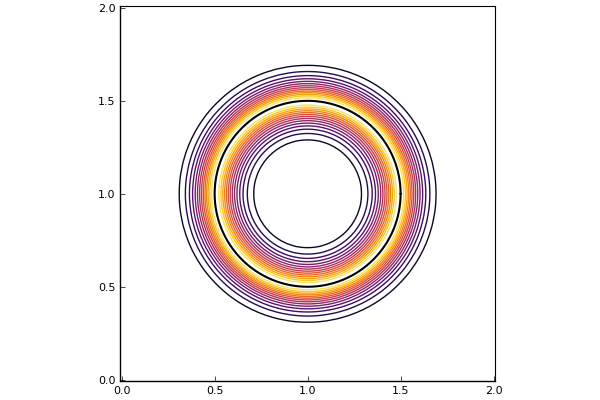

In [11]:
xg, yg = coordinates(u,dx=Δx);
plot(xg,yg,u)
plot!(xb,yb,linecolor=:black,linewidth=1.5)

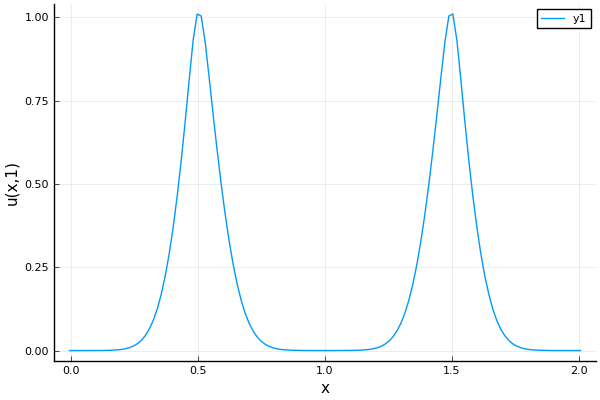

In [12]:
plot(xg,u[65,:],xlabel="x",ylabel="u(x,1)")